# KMA ANALYSIS

In [1]:
# basics
import os, sys
import numpy as np

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# data viewer
from sscode.data import Loader, load_moana_hindcast_ss
from sscode.kma import KMA_simple
from sscode.config import default_region_reduced

# warnings
import warnings
warnings.filterwarnings('ignore')


 loading the sea-level-pressure fields... 


 loading daily resampled data... 



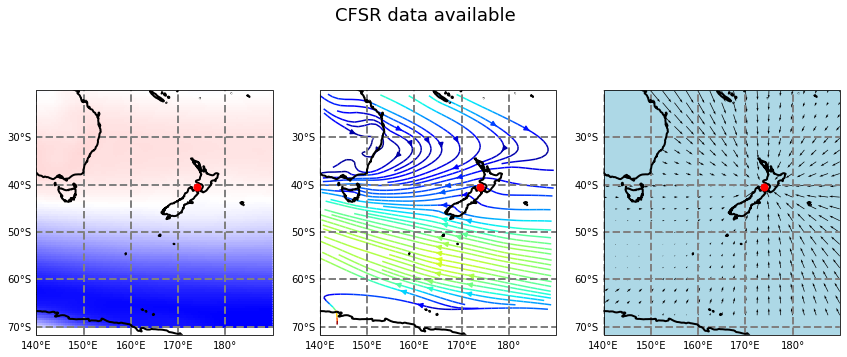


 loading the Moana v2 hindcast data... 



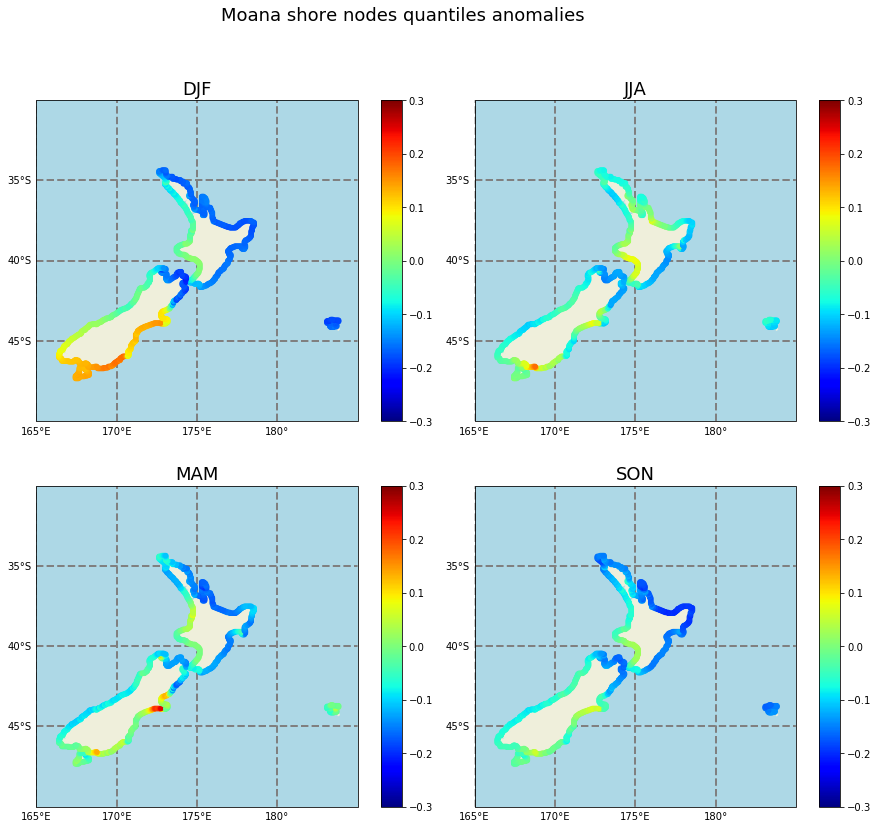


 loading and plotting the UHSLC tidal guages... 



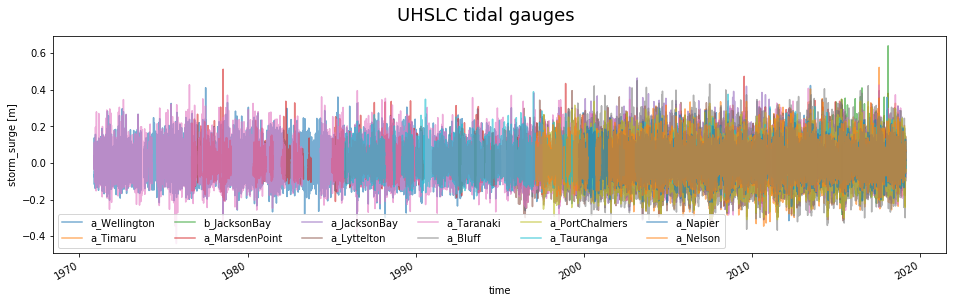

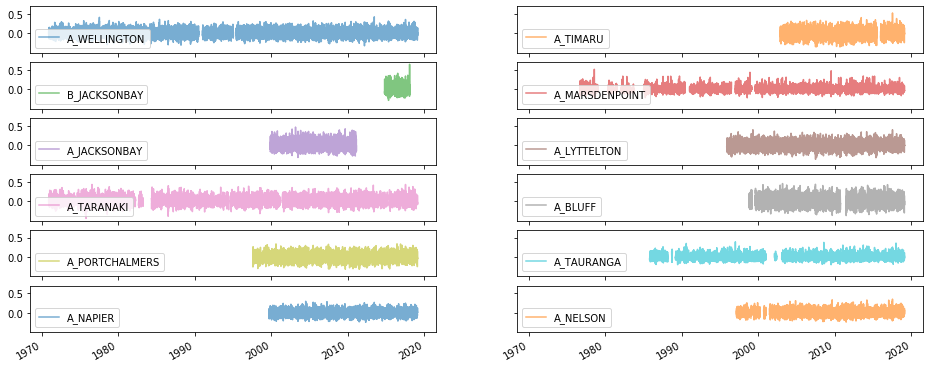

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc']
)


 plotting 5 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



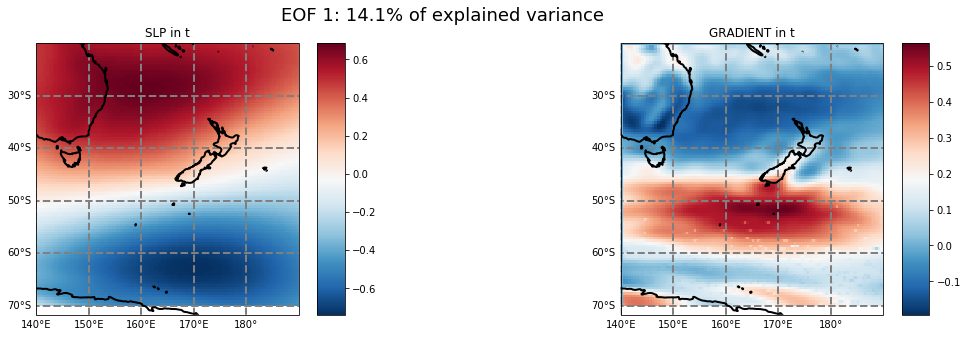

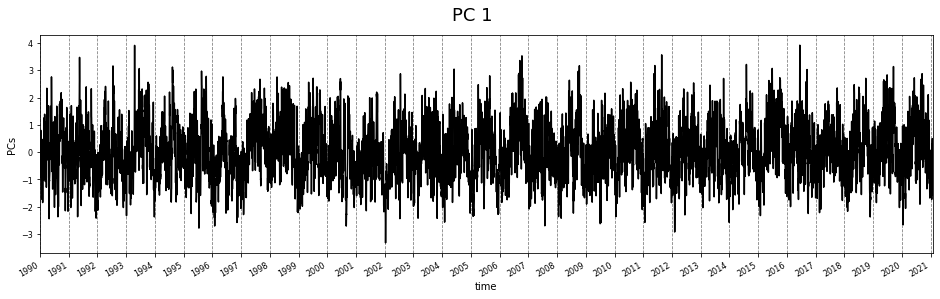

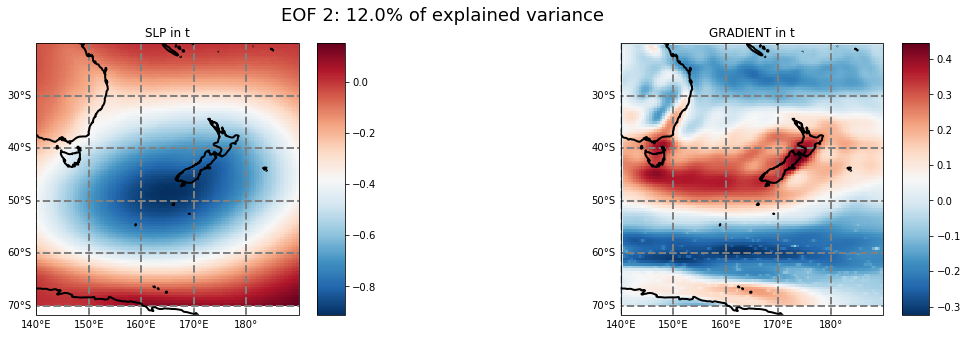

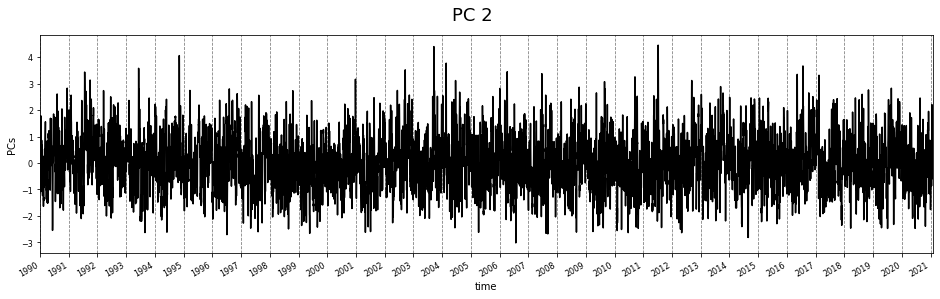

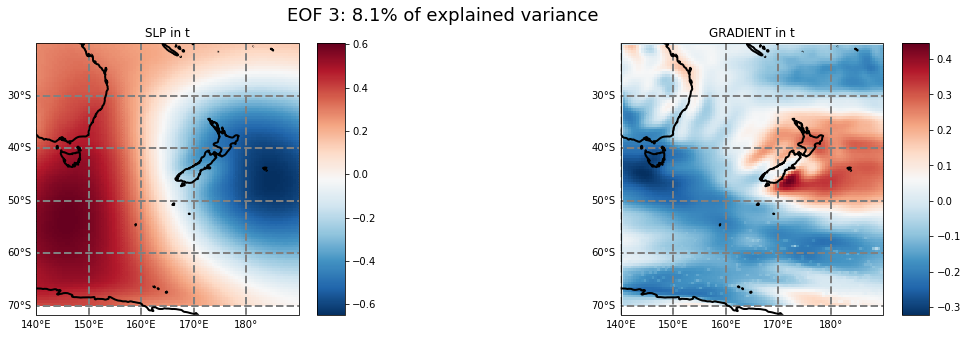

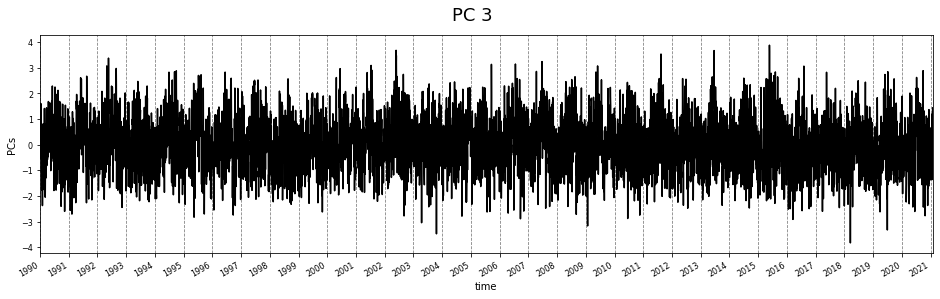

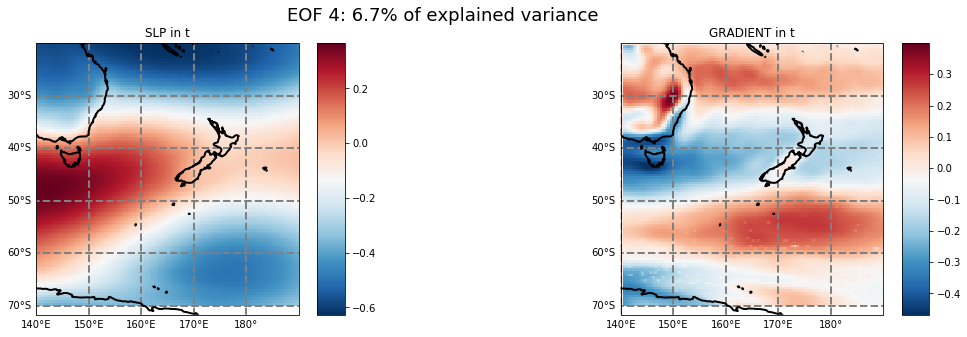

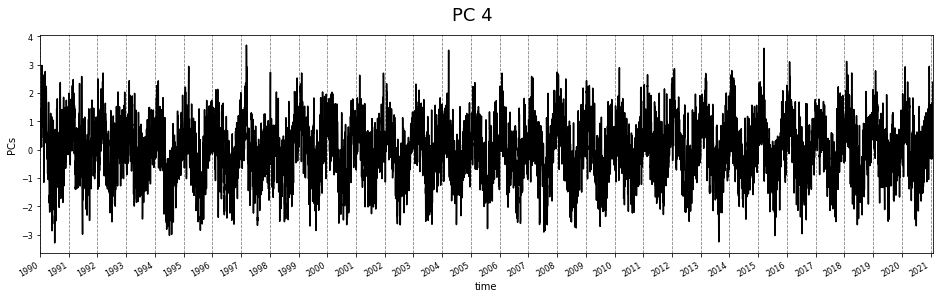

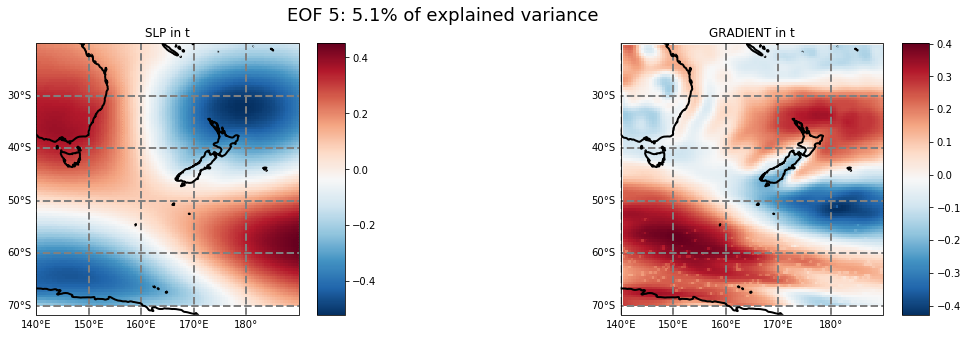

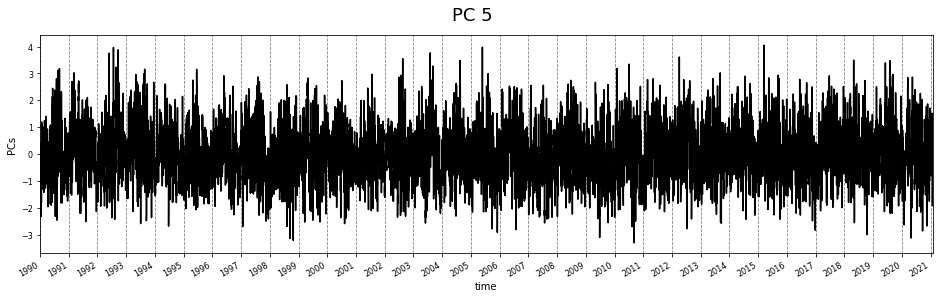

In [3]:
# load / calculate the regional pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    import xarray as xr
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    from sscode.plotting.pca import plot_pcs
    plot_pcs(pcs_cfsr,n_plot=5)

## calculate the wheather types


 loading the Moana v2 hindcast data (ss)... 


 The score of the KMA model is: 



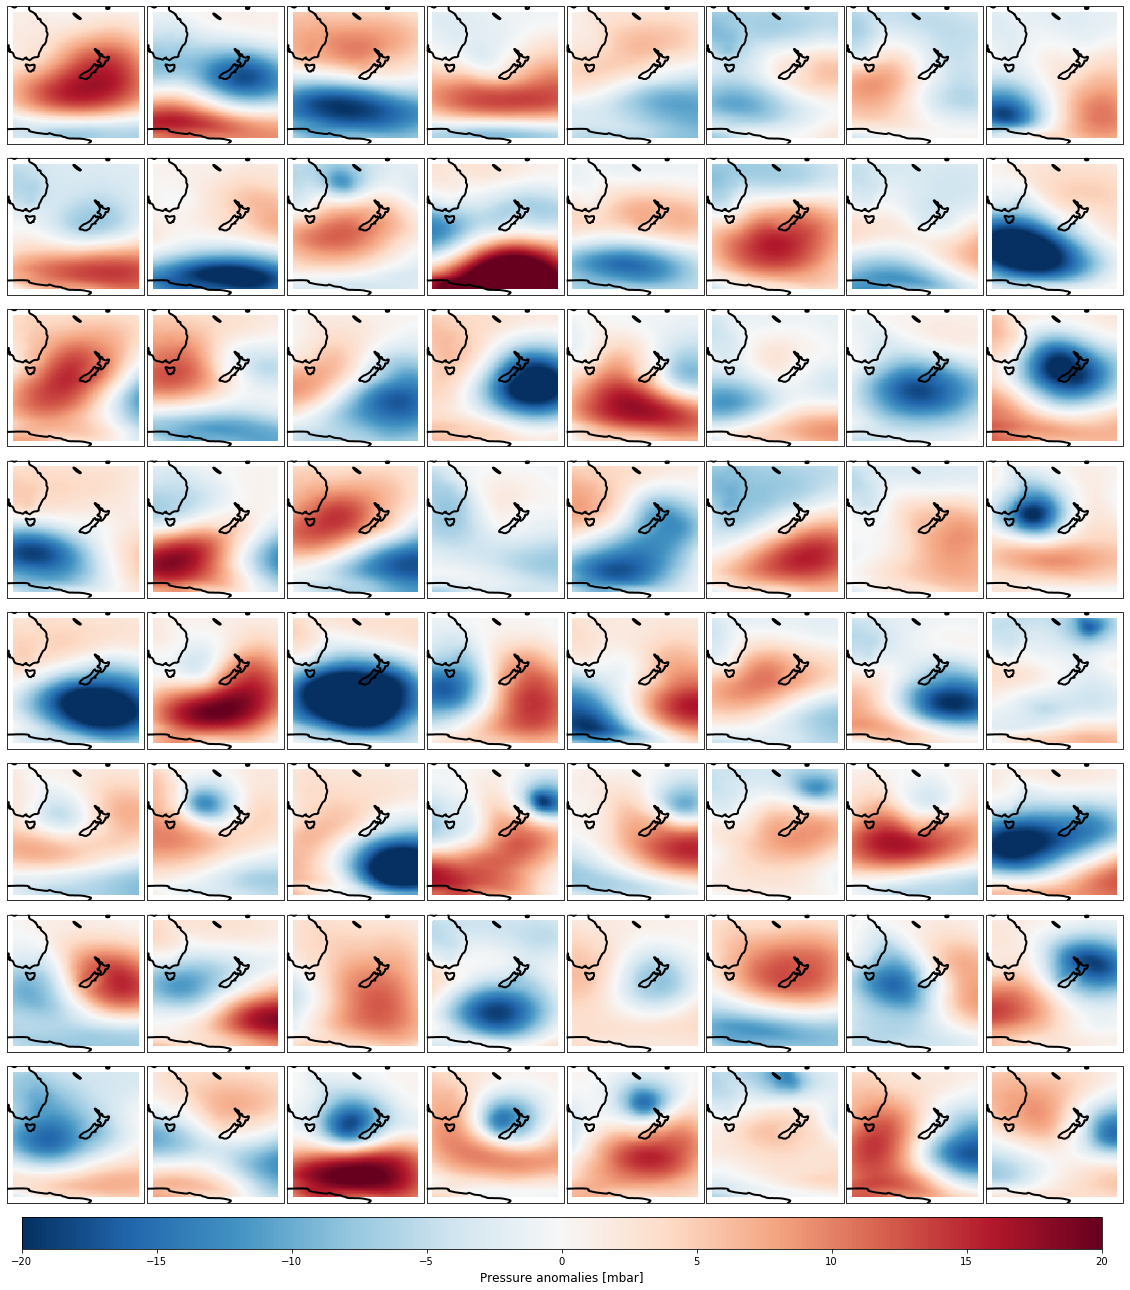

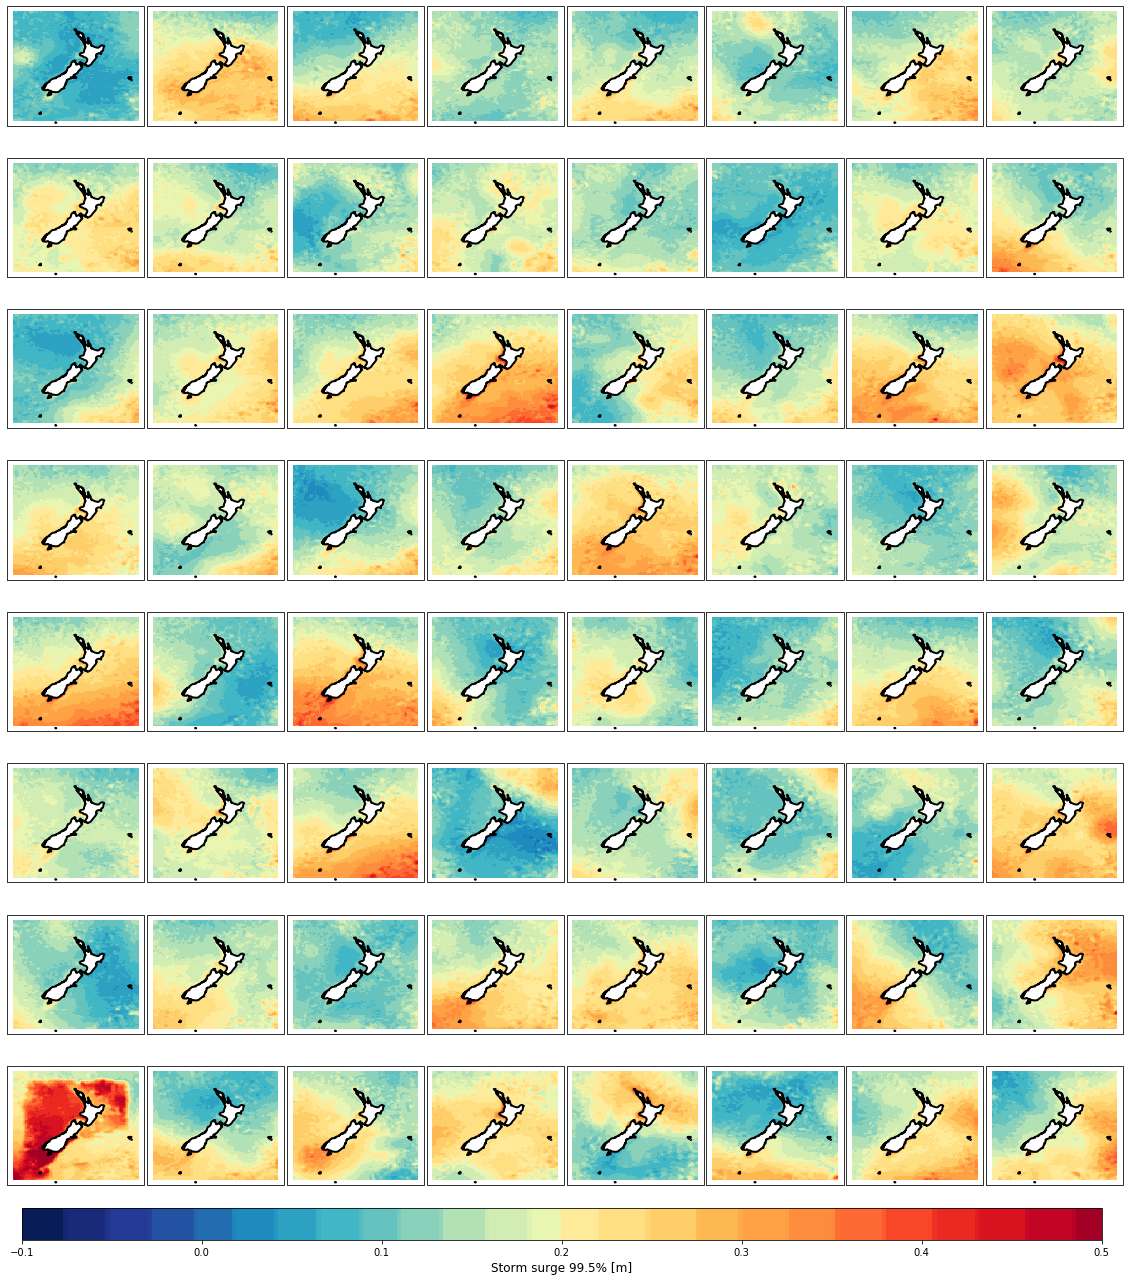

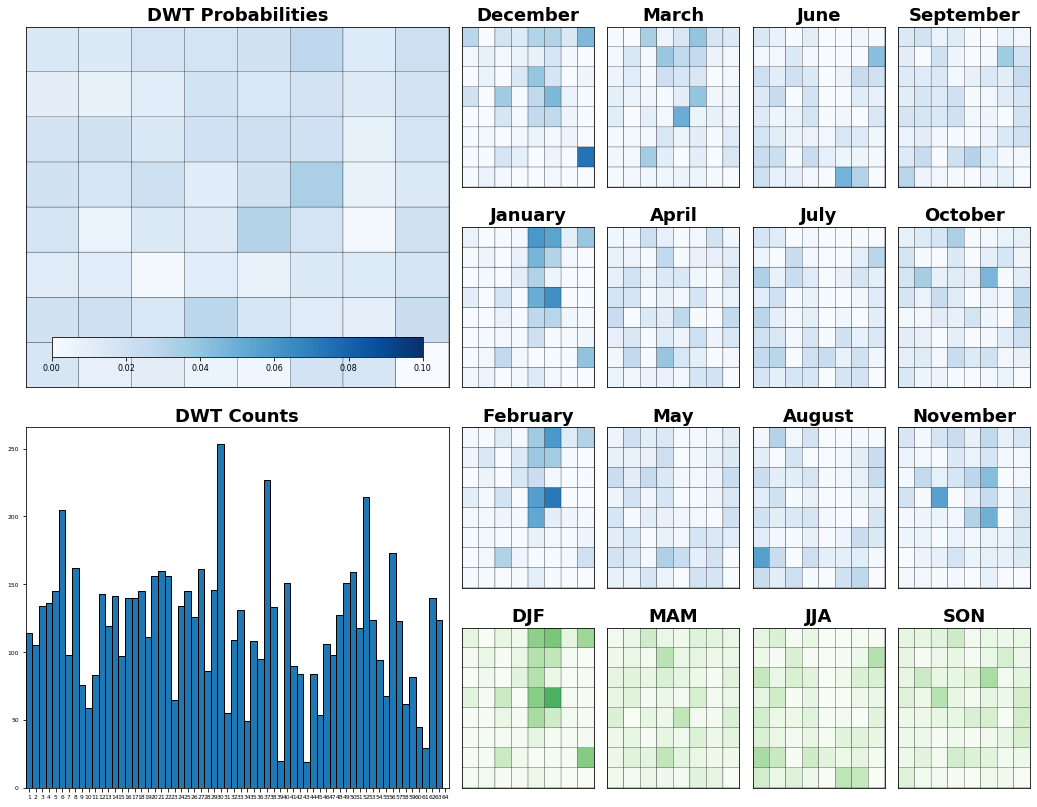

In [4]:
kms_data = KMA_simple(
    load_cfsr_moana_uhslc.predictor_slp,
    load_moana_hindcast_ss(daily=True),
    pcs_cfsr, n_clusters=64
)

In [5]:
kms_data

<xarray.Dataset>
Dimensions:           (lat: 117, latitude: 101, lon: 100, longitude: 101, n_clusters: 64, n_components: 72, test_time: 839, train_time: 7546)
Coordinates:
  * longitude         (longitude) float32 140.0 140.5 141.0 ... 189.5 190.0
  * latitude          (latitude) float32 -20.0 -20.5 -21.0 ... -69.0 -69.5 -70.0
  * n_clusters        (n_clusters) int64 0 1 2 3 4 5 6 ... 57 58 59 60 61 62 63
  * lat               (lat) float64 -51.98 -51.83 -51.68 ... -31.34 -31.13
  * lon               (lon) float64 161.0 161.3 161.5 ... 184.5 184.7 185.0
    quantile          float64 0.995
  * train_time        (train_time) datetime64[ns] 1994-01-17 ... 2014-09-14
  * test_time         (test_time) datetime64[ns] 2014-09-15 ... 2016-12-31
Dimensions without coordinates: n_components
Data variables:
    bmus              (train_time) int32 21 15 51 5 5 5 14 ... 15 15 48 52 52 52
    bmus_pred         (test_time) int32 52 49 49 52 19 19 ... 27 38 25 6 56 56
    cluster_centers   (n_clusters, n_components) float64 16.16 -93.46 ... 0.7162
    slp_clusters      (n_clusters, latitude, longitude) float64 1.014e+05 ... 9.86e+04
    ss_clusters_mean  (n_clusters, lat, lon) float32 -0.05950955 ... 0.053620696
    ss_clusters_max   (n_clusters, lat, lon) float64 0.1314 0.127 ... 0.1835

```python

from sscode.statistical import gev_matrix

gev_matrix(
    load_moana_hindcast_ss(daily=True).sel(
        time=kms_data.train_time[kms_data.bmus==1]
    ), 'lon', 'lat'
) # TODO: implement gev analysis over the clusters

```

## calculate prediction errors


 loading the Moana v2 hindcast data (ss)... 



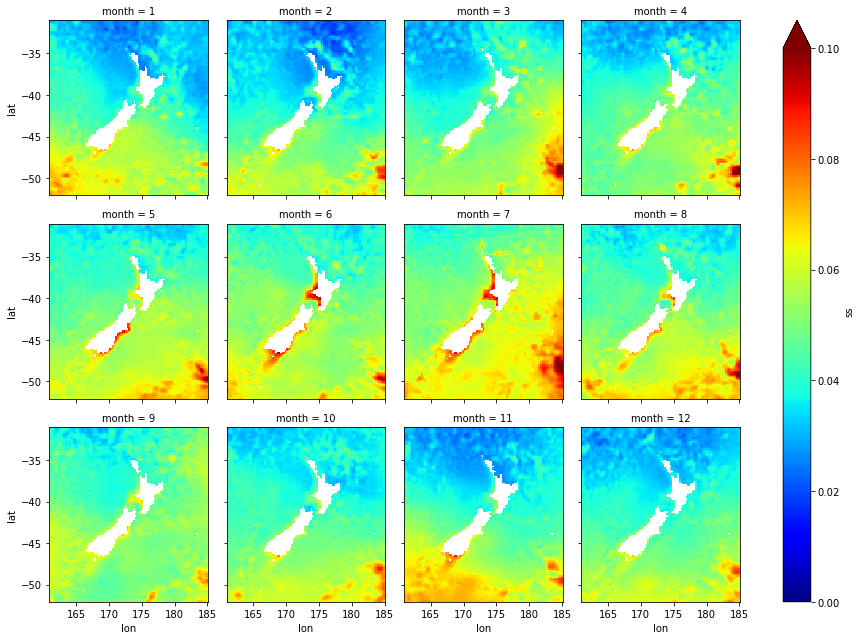

In [6]:
np.abs(load_moana_hindcast_ss(daily=True).sel(time=kms_data.test_time) - \
    kms_data.ss_clusters_mean.sel(n_clusters=kms_data.bmus_pred.values).values)\
    .groupby('time.month').mean().plot(
        col='month',col_wrap=4,vmin=0.0,vmax=0.1,cmap='jet'
)